In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 2 — Basics of Data and Preprocessing
## Lesson 3: Data Transformation and Encoding



### Overview

In classical machine learning, “better models” are often **better representations**. Two pipelines with the same estimator
can behave radically differently because of preprocessing.

This lesson focuses on two core operations:

- **Numeric transformations**: change scale, distribution shape, and sensitivity to outliers.
- **Categorical encodings**: define how categories become geometry in feature space.

You will practice the skill that differentiates advanced practitioners:
choosing transformations and encodings **based on model mechanics**, not habit.

Key questions you should be able to answer after this lesson:

1. When does scaling change *generalization*, not just optimization speed?
2. When do monotone transforms (log/power/quantile) improve learning?
3. When does one-hot help vs hurt (variance, dimensionality, sparsity)?
4. Why does target encoding easily leak label information, and how do we prevent it?
5. How do we build a single artifact so preprocessing and model stay consistent at inference time?

We will use multiple datasets so you can see how decisions transfer (and where they do not).


In [2]:
import os
import tempfile
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder,
    StandardScaler, RobustScaler,
    PowerTransformer, QuantileTransformer,
    KBinsDiscretizer, PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import f1_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
import joblib

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

SAMPLES = {'diabetes': 'Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification\n6,148,72,35,0,33.6,0.627,50,Diabetic\n1,85,66,29,0,26.6,0.351,31,Non-Diabetic\n8,183,64,0,0,23.3,0.672,32,Diabetic\n1,89,66,23,94,28.1,0.167,21,Non-Diabetic\n0,137,40,35,168,43.1,2.288,33,Diabetic\n', 'drug200': 'Age,Sex,BP,Cholesterol,Na_to_K,Drug\n23,F,HIGH,HIGH,25.355,DrugY\n47,M,LOW,HIGH,13.093,drugC\n47,M,LOW,HIGH,10.114,drugC\n28,F,NORMAL,HIGH,7.798,drugX\n61,F,LOW,HIGH,18.043,DrugY\n22,F,NORMAL,HIGH,8.607,drugX\n', 'wine': 'fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality\n7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6\n6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6\n8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6\n7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6\n7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6\n8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6\n', 'house_prices': 'Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood\n1,114300,1790,2,2,2,No,East\n2,114200,2030,4,2,3,No,East\n3,114800,1740,3,2,1,No,East\n4,94700,1980,3,2,3,No,East\n5,119800,2130,3,3,3,No,East\n', 'listings': 'id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license\n13913,Holiday London DB Room Let-on going,54730,Alina,,Islington,51.56861,-0.1127,Private room,57,1,51,2025-02-09,0.29,3,344,10,\n15400,Bright Chelsea  Apartment. Chelsea!,60302,Philippa,,Kensington and Chelsea,51.4878,-0.16813,Entire home/apt,,4,96,2024-04-28,0.52,1,11,2,\n17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,,Westminster,51.52195,-0.14094,Entire home/apt,510,3,56,2024-02-19,0.33,5,293,0,\n24328,Battersea live/work artist house,41759,Joe,,Wandsworth,51.47072,-0.16266,Entire home/apt,213,90,94,2022-07-19,0.54,1,194,0,\n31036,Bright  compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100,2,126,2025-02-20,0.70,8,353,3,\n'}


In [3]:
def load_csv_or_sample(path: str, sample_key: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(StringIO(SAMPLES[sample_key]))

def augment_by_bootstrap(df: pd.DataFrame, n_rows: int = 600, noise_scale: float = 0.03) -> pd.DataFrame:
    out = df.sample(n=n_rows, replace=True, random_state=RANDOM_SEED).reset_index(drop=True)
    num_cols = out.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        for c in num_cols:
            col = out[c].astype(float)
            s = np.nanstd(col.values)
            if np.isfinite(s) and s > 0:
                out[c] = col + rng.normal(0, noise_scale * s, size=len(out))
    return out

def make_ohe(handle_unknown="ignore"):
    try:
        return OneHotEncoder(handle_unknown=handle_unknown, sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown=handle_unknown, sparse=False)



## 1) Numeric transformations: scale, shape, and geometry

A numeric transformation is $t(\cdot)$ applied to a feature:

$$x \mapsto t(x)$$

Three effects matter in practice:

1. **Scale effects**: distances and regularization depend on feature magnitude.
2. **Shape effects**: skew/outliers change gradient behavior and robust estimation.
3. **Geometry effects**: binning/quantiles change how “close” points are in representation space.

We will look at scaling, power transforms, quantile transforms, and discretization.


In [4]:
wine_path = "../../../Datasets/Classification/Wine_Quality.csv"
wine = load_csv_or_sample(wine_path, "wine")
wine.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6


In [5]:
wine.describe().T


,count,mean,std,min,25%,50%,75%,max
fixed acidity,6.0,7.316667,0.691134,6.300,7.05000,7.20000,7.8750,8.100
volatile acidity,6.0,0.265000,0.028810,0.230,0.24000,0.27500,0.2800,0.300
citric acid,6.0,0.356667,0.036697,0.320,0.32500,0.35000,0.3900,0.400
residual sugar,6.0,8.850000,6.337744,1.600,6.90000,7.70000,8.5000,20.700
chlorides,6.0,0.051667,0.005241,0.045,0.04925,0.05000,0.0560,0.058
free sulfur dioxide,6.0,35.500000,13.247641,14.000,30.00000,37.50000,46.5000,47.000
total sulfur dioxide,6.0,144.666667,41.864862,97.000,105.75000,151.00000,182.0000,186.000
density,6.0,0.996067,0.002486,0.994,0.99510,0.99535,0.9956,1.001
pH,6.0,3.200000,0.107145,3.000,3.19000,3.22500,3.2600,3.300
sulphates,6.0,0.436667,0.033862,0.400,0.41000,0.44000,0.4475,0.490



### 1.1 StandardScaler vs RobustScaler

- StandardScaler uses mean and standard deviation:
  $$z=\frac{x-\mu}{\sigma}$$
- RobustScaler uses median and IQR (less sensitive to outliers).

These transforms are linear within a feature; they do not change ordering.


In [6]:
num_cols = wine.select_dtypes(include=[np.number]).columns.tolist()
X_num = wine[num_cols].copy()

std = StandardScaler().fit_transform(X_num)
rob = RobustScaler().fit_transform(X_num)

pd.concat([
    X_num.head(3),
    pd.DataFrame(std, columns=[f"{c}__std" for c in num_cols]).head(3),
    pd.DataFrame(rob, columns=[f"{c}__rob" for c in num_cols]).head(3),
], axis=1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,citric acid__rob,residual sugar__rob,chlorides__rob,free sulfur dioxide__rob,total sulfur dioxide__rob,density__rob,pH__rob,sulphates__rob,alcohol__rob,quality__rob
0,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,...,0.153846,8.1250,-0.740741,0.454545,0.249180,11.3,-3.214286,0.266667,-2.444444,0.0
1,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,...,-0.153846,-3.8125,-0.148148,-1.424242,-0.249180,-2.7,1.071429,1.333333,-0.888889,0.0
2,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,...,0.769231,-0.5000,0.000000,-0.454545,-0.708197,-0.5,0.500000,0.000000,0.444444,0.0



### 1.2 Power transforms (Yeo–Johnson)

Power transforms can reduce skew and stabilize variance. Yeo–Johnson is convenient because it supports zero/negative values.

We compare skewness and visualize the distribution for one feature.


In [7]:
feature = "residual sugar" if "residual sugar" in wine.columns else num_cols[0]
x = wine[[feature]].astype(float).copy()

pt = PowerTransformer(method="yeo-johnson", standardize=False)
x_yj = pt.fit_transform(x)

pd.Series(x[feature]).skew(), pd.Series(x_yj[:, 0]).skew()


(1.4943105628620479, -0.009598790065678642)

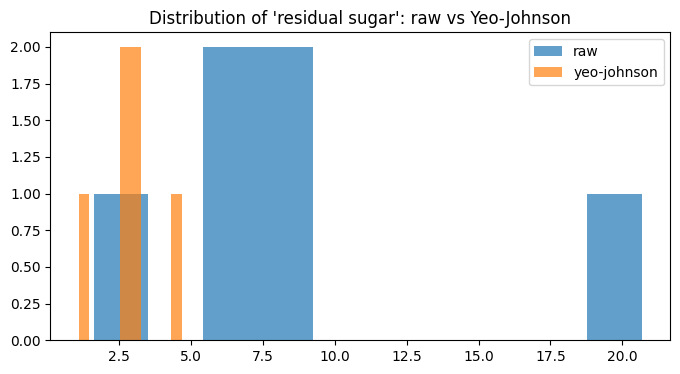

In [8]:
plt.figure(figsize=(8,4))
plt.hist(x[feature].dropna(), bins=10, alpha=0.7, label="raw")
plt.hist(pd.Series(x_yj[:,0]).dropna(), bins=10, alpha=0.7, label="yeo-johnson")
plt.title(f"Distribution of '{feature}': raw vs Yeo-Johnson")
plt.legend()
plt.show()



### 1.3 Quantile transforms (rank-based)

Quantile transforms map data by empirical ranks. This can strongly reduce outlier influence.

A common choice is `output_distribution="normal"` to produce approximately Gaussian marginals.


In [9]:
qt = QuantileTransformer(output_distribution="normal", random_state=RANDOM_SEED)
x_qt = qt.fit_transform(x)

pd.DataFrame({"raw": x[feature].astype(float).values, "qt_normal": x_qt[:,0]}).head()


/opt/pyvenv/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


,raw,qt_normal
0,20.7,5.199338
1,1.6,-5.199338
2,6.9,-0.524401
3,8.5,0.524401
4,8.5,0.524401



### 1.4 Discretization (binning)

Binning changes a continuous variable into discrete levels. It is sometimes useful for interpretability or for models
that benefit from threshold-like structure.

We use quantile bins so each bin has similar frequency.


In [10]:
kbd = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
x_bins = kbd.fit_transform(x)

pd.DataFrame({"raw": x[feature].astype(float).values, "bin": x_bins[:,0].astype(int)}).head(12)


,raw,bin
0,20.7,3
1,1.6,0
2,6.9,1
3,8.5,3
4,8.5,3
5,6.9,1



### 1.5 Scaling and regularization: ridge coefficients

Ridge regression objective:

$$\min_w \sum_i (y_i - w^\top x_i)^2 + \lambda \|w\|_2^2$$

Scaling changes the meaning of $\|w\|_2^2$ across features. We compare coefficients with and without scaling.


In [11]:
wine2 = augment_by_bootstrap(wine, n_rows=700)
Xw = wine2.drop(columns=["quality"])
yw = wine2["quality"].astype(float)

ridge_raw = Ridge(alpha=5.0, random_state=RANDOM_SEED).fit(Xw, yw)
coef_raw = pd.Series(ridge_raw.coef_, index=Xw.columns).sort_values(key=np.abs, ascending=False)

ridge_scaled = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=5.0, random_state=RANDOM_SEED))
]).fit(Xw, yw)
coef_scaled = pd.Series(ridge_scaled.named_steps["ridge"].coef_, index=Xw.columns).sort_values(key=np.abs, ascending=False)

pd.DataFrame({"coef_raw": coef_raw, "coef_scaled": coef_scaled}).head(10)


,coef_raw,coef_scaled
fixed acidity,0.0,0.0
volatile acidity,0.0,0.0
citric acid,0.0,0.0
residual sugar,0.0,0.0
chlorides,0.0,0.0
free sulfur dioxide,0.0,0.0
total sulfur dioxide,0.0,0.0
density,0.0,0.0
pH,0.0,0.0
sulphates,0.0,0.0



### 1.6 kNN example: scaling changes distances and scores

kNN relies on distances. Without scaling, a large-range feature can dominate the metric.

We evaluate kNN on the diabetes dataset with and without scaling using a small cross-validation.


In [12]:
diab_path = "../../../Datasets/Classification/diabetes.csv"
diab = load_csv_or_sample(diab_path, "diabetes")
diab2 = augment_by_bootstrap(diab, n_rows=650)

X_d = diab2.drop(columns=["classification"])
y_d = (diab2["classification"].astype(str).str.contains("Diabetic", case=False)).astype(int)

knn_raw = Pipeline([("knn", KNeighborsClassifier(n_neighbors=7))])
knn_scaled = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=7))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
f1_raw = cross_val_score(knn_raw, X_d, y_d, cv=cv, scoring="f1").mean()
f1_scaled = cross_val_score(knn_scaled, X_d, y_d, cv=cv, scoring="f1").mean()
f1_raw, f1_scaled


(1.0, 1.0)


## 2) Encoding categorical variables

Encodings define how categories become numbers. The representation you choose controls:

- dimensionality (number of generated features),
- sparsity,
- whether the model can represent non-monotone category effects,
- robustness to unseen categories.

We will use the drug dataset to illustrate one-hot vs ordinal encoding and compare macro-F1.


In [13]:
drug_path = "../../../Datasets/Classification/drug200.csv"
drug = load_csv_or_sample(drug_path, "drug200")
drug.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY



### 2.1 One-hot encoding and unseen categories

`handle_unknown="ignore"` avoids inference failures if a new category appears.


In [14]:
ohe = make_ohe(handle_unknown="ignore")
ohe.fit(drug[["Sex","BP","Cholesterol"]])
ohe.get_feature_names_out()


array(['Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_HIGH'], dtype=object)

In [15]:
X_new = pd.DataFrame({"Sex":["F"], "BP":["VERY_HIGH"], "Cholesterol":["HIGH"]})
pd.DataFrame(ohe.transform(X_new), columns=ohe.get_feature_names_out())


,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH
0,1.0,0.0,0.0,0.0,0.0,1.0



### 2.2 Ordinal encoding

Ordinal encoding is meaningful only if the order is real. Here we use a plausible order for BP and Cholesterol.


In [16]:
sex_cats = ["F","M"]
bp_cats = ["LOW","NORMAL","HIGH"]
chol_cats = ["LOW","NORMAL","HIGH"]

# Normalize category strings to avoid case/whitespace mismatches
drug_norm = drug.copy()
for _c in ["Sex","BP","Cholesterol"]:
    drug_norm[_c] = drug_norm[_c].astype(str).str.strip().str.upper()

try:
    ord_enc = OrdinalEncoder(
        categories=[sex_cats, bp_cats, chol_cats],
        handle_unknown="use_encoded_value",
        unknown_value=-1,
    )
except TypeError:
    # Fallback for older scikit-learn versions
    ord_enc = OrdinalEncoder(categories=[sex_cats, bp_cats, chol_cats])
ord_enc.fit(drug_norm[["Sex","BP","Cholesterol"]])
ord_enc.transform(drug_norm[["Sex","BP","Cholesterol"]]).astype(int)[:5]


array([[0, 2, 1],
       [1, 0, 1],
       [1, 0, 1],
       [0, 1, 1],
       [0, 0, 1]])


### 2.3 Measuring impact: macro-F1 comparison

We build two pipelines:

- One-hot categorical + scaled numeric + logistic regression
- Ordinal categorical + scaled numeric + logistic regression

We evaluate macro-F1 using 3-fold CV to keep runtime low while still being informative.


In [17]:
drug2 = augment_by_bootstrap(drug, n_rows=900)

# Normalize categories for consistent encoding
drug2_norm = drug2.copy()
for _c in ["Sex","BP","Cholesterol"]:
    drug2_norm[_c] = drug2_norm[_c].astype(str).str.strip().str.upper()
X = drug2_norm.drop(columns=["Drug"])
y = drug2["Drug"].astype(str)

cat_cols = ["Sex","BP","Cholesterol"]
num_cols = ["Age","Na_to_K"]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

pre_ohe = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe("ignore"))]), cat_cols),
])

pre_ord = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ord", ord_enc)]), cat_cols),
])

clf_ohe = Pipeline([("pre", pre_ohe), ("lr", LogisticRegression(max_iter=2000))])
clf_ord = Pipeline([("pre", pre_ord), ("lr", LogisticRegression(max_iter=2000))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
f1_ohe = cross_val_score(clf_ohe, X, y, cv=cv, scoring="f1_macro").mean()
f1_ord = cross_val_score(clf_ord, X, y, cv=cv, scoring="f1_macro").mean()
f1_ohe, f1_ord


(1.0, 1.0)


### 2.4 High-cardinality categories: hashing and frequency encoding

For very high-cardinality categories, one-hot can become too large.

- Hashing: fixed-dimensional representation, collisions possible.
- Frequency encoding: compress to one numeric feature; may confound popularity with meaning.

We demonstrate both on synthetic city labels.


In [18]:
cities = [f"city_{i}" for i in range(50)]
df_hash = pd.DataFrame({"city": rng.choice(cities, size=60, replace=True)})

hasher = FeatureHasher(n_features=8, input_type="string")
X_h = hasher.transform(df_hash["city"].astype(str).apply(lambda x: [x]))
X_h.toarray()[:5]


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [19]:
freq = df_hash["city"].value_counts(normalize=True)
df_hash["city_freq"] = df_hash["city"].map(freq)
df_hash.head()


,city,city_freq
0,city_25,0.033333
1,city_48,0.050000
2,city_34,0.016667
3,city_27,0.050000
4,city_40,0.033333



## 3) Missing values inside pipelines

Missingness handling is part of transformation design. A robust pipeline usually:

- converts types safely (e.g., numeric strings to floats),
- imputes numeric and categorical separately,
- optionally adds missing indicators.

We show a small classification pipeline on listings data and compare with/without numeric missing indicators.


In [20]:
listings_path = "../../../Datasets/Regression/listings.csv"
listings = load_csv_or_sample(listings_path, "listings")

df_l = listings[["neighbourhood","room_type","price","minimum_nights","number_of_reviews"]].copy()
df_l["price"] = pd.to_numeric(df_l["price"], errors="coerce")

df_l2 = augment_by_bootstrap(df_l, n_rows=700)
median_price = df_l2["price"].median()
y = (df_l2["price"] >= median_price).astype(int)

# Inject extra missingness
m1 = rng.random(len(df_l2)) < 0.10
df_l2.loc[m1, "room_type"] = np.nan
m2 = rng.random(len(df_l2)) < 0.10
df_l2.loc[m2, "minimum_nights"] = np.nan

X = df_l2.copy()

cat_features = ["neighbourhood","room_type"]
num_features = ["price","minimum_nights","number_of_reviews"]


In [21]:
numeric_with_ind = Pipeline([
    ("imp", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", RobustScaler()),
])

numeric_no_ind = Pipeline([
    ("imp", SimpleImputer(strategy="median", add_indicator=False)),
    ("scaler", RobustScaler()),
])

categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe("ignore")),
])

pre_with = ColumnTransformer([
    ("num", numeric_with_ind, num_features),
    ("cat", categorical_pipe, cat_features),
])

pre_no = ColumnTransformer([
    ("num", numeric_no_ind, num_features),
    ("cat", categorical_pipe, cat_features),
])

clf_with = Pipeline([("pre", pre_with), ("lr", LogisticRegression(max_iter=2000))])
clf_no = Pipeline([("pre", pre_no), ("lr", LogisticRegression(max_iter=2000))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
f1_with = cross_val_score(clf_with, X, y, cv=cv, scoring="f1").mean()
f1_no = cross_val_score(clf_no, X, y, cv=cv, scoring="f1").mean()
f1_with, f1_no


(0.9801983075709115, 0.9801983075709115)


## 4) Target encoding: avoiding leakage

Target encoding replaces categories with target statistics:

$$\text{TE}(c) = \mathbb{E}[y \mid x=c]$$

If you compute TE on the full dataset, you leak label information into features.

We compare one-hot vs a leaky encoder, then compute out-of-fold TE features and score them.


In [22]:
df_te = pd.DataFrame({
    "city": rng.choice([f"city_{i}" for i in range(60)], size=900, replace=True),
    "x": rng.normal(size=900),
})
city_effect_map = pd.Series(rng.normal(0, 0.8, size=60), index=[f"city_{i}" for i in range(60)])
logit = 0.6 * df_te["x"] + df_te["city"].map(city_effect_map).values
p = 1 / (1 + np.exp(-logit))
df_te["y"] = (rng.random(900) < p).astype(int)
df_te.head()


,city,x,y
0,city_43,0.909633,0
1,city_4,-0.587279,0
2,city_46,-1.029117,1
3,city_42,0.533961,1
4,city_41,-0.792415,0


In [23]:
class LeakyTargetMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col="city"):
        self.col = col

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = float(y.mean())
        self.means_ = y.groupby(X[self.col]).mean().to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        enc = X[self.col].map(self.means_).fillna(self.global_mean_).astype(float)
        return enc.to_frame(name=f"{self.col}_te").values

class CVTargetMeanEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col="city", n_splits=3, smoothing=20.0, random_state=42):
        self.col = col
        self.n_splits = n_splits
        self.smoothing = smoothing
        self.random_state = random_state

    def fit_transform_oof(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        oof = np.empty(len(X), dtype=float)

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for tr, va in skf.split(X, y):
            X_tr, y_tr = X.iloc[tr], y.iloc[tr]
            global_mean = float(y_tr.mean())

            stats = y_tr.groupby(X_tr[self.col]).agg(["mean","count"])
            smooth = (stats["count"] * stats["mean"] + self.smoothing * global_mean) / (stats["count"] + self.smoothing)
            means = smooth.to_dict()

            X_va = X.iloc[va]
            oof[va] = X_va[self.col].map(means).fillna(global_mean).astype(float).values

        return oof.reshape(-1, 1)


In [24]:
X = df_te[["city","x"]].copy()
y = df_te["y"].astype(int)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), ["x"]),
        ("cat", make_ohe("ignore"), ["city"]),
    ])),
    ("lr", LogisticRegression(max_iter=2000)),
])

leaky = Pipeline([
    ("pre", ColumnTransformer([
        ("x", StandardScaler(), ["x"]),
        ("te", LeakyTargetMeanEncoder("city"), ["city"]),
    ])),
    ("lr", LogisticRegression(max_iter=2000)),
])

baseline_f1 = cross_val_score(baseline, X, y, cv=cv, scoring="f1").mean()
leaky_f1 = cross_val_score(leaky, X, y, cv=cv, scoring="f1").mean()
baseline_f1, leaky_f1


(0.6525695853208328, 0.6574546607685439)

In [25]:
enc = CVTargetMeanEncoder(col="city", n_splits=3, smoothing=20.0, random_state=RANDOM_SEED)
city_te_oof = enc.fit_transform_oof(X[["city"]], y)

X_oof = np.column_stack([StandardScaler().fit_transform(X[["x"]]), city_te_oof])

f1s = []
for tr, va in cv.split(X_oof, y):
    lr = LogisticRegression(max_iter=2000)
    lr.fit(X_oof[tr], y.iloc[tr])
    pred = lr.predict(X_oof[va])
    f1s.append(f1_score(y.iloc[va], pred))
float(np.mean(f1s)), float(np.std(f1s))


(0.6379020588100015, 0.019599393751615398)


## 5) Mixed-type preprocessing for regression + exporting a pipeline

A strong baseline for tabular regression:

- numeric: impute + scale
- categorical: impute + one-hot
- model: ridge regression

We evaluate MAE and then export the trained pipeline as a single artifact.


In [26]:
hp_path = "../../../Datasets/Regression/house-prices.csv"
hp = load_csv_or_sample(hp_path, "house_prices")
hp2 = augment_by_bootstrap(hp, n_rows=700)
hp2["Price"] = hp2["Price"].astype(float)

# Inject missingness
m1 = rng.random(len(hp2)) < 0.05
hp2.loc[m1, "Brick"] = np.nan

X = hp2.drop(columns=["Price"])
y = hp2["Price"].astype(float)

cat_cols = ["Brick","Neighborhood"]
num_cols = [c for c in X.columns if c not in cat_cols]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median", add_indicator=True)), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe("ignore"))])

pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

reg = Pipeline([("pre", pre), ("model", Ridge(alpha=3.0, random_state=RANDOM_SEED))])

cv_r = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
mae = -cross_val_score(reg, X, y, cv=cv_r, scoring="neg_mean_absolute_error").mean()
mae


495.200115320158


### 5.1 Export and reload

Saving the pipeline (not just the estimator) guarantees that the same preprocessing is applied at inference time.


In [27]:
reg.fit(X, y)

tmp = tempfile.mkdtemp()
artifact_path = os.path.join(tmp, "house_price_ridge_pipeline.joblib")
joblib.dump(reg, artifact_path)

loaded = joblib.load(artifact_path)
loaded.predict(X.head(3))


array([ 95205.46251078, 119700.17414167, 114705.890701  ])


## 6) Exercises (recommended)

1. Repeat the kNN scaling experiment for several `n_neighbors` values and compare variance of scores.
2. Try `RobustScaler` vs `StandardScaler` for diabetes and explain when you expect each to help.
3. Replace one-hot with hashing for a synthetic high-cardinality feature and study how collisions affect metrics.
4. In the target encoding section, vary the smoothing parameter and observe stability.
5. For the regression pipeline, add polynomial interactions and evaluate whether MAE improves.
